In [12]:
# ------------------------------
# 1. Import Libraries
# ------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from matplotlib.ticker import FuncFormatter


In [3]:
# ------------------------------
# 2. Load Dataset
# ------------------------------
# Replace with your dataset path
df = pd.read_csv("vehicles.csv")

# Preview data
df.head()


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [4]:
# ------------------------------
# 3. Data Cleaning
# ------------------------------

print("Starting Part 3: Data Cleaning...")

# Remove irrelevant or high-text columns
drop_cols = ["id", "url", "region_url", "VIN", "image_url", "description"]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True, errors="ignore")

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Filter unrealistic values
# Remove unrealistic car prices
df = df[(df["price"] >= 1000) & (df["price"] <= 120000)]

# Validate year range (assuming cars between 1985 and 2025)
df = df[(df["year"] >= 2000) & (df["year"] <= 2025)]

# Validate odometer (remove negative or extremely high mileage)
df = df[(df["odometer"] > 0) & (df["odometer"] <= 300000)]

# Standardize categorical values
# Convert to lowercase
cat_cols = ["manufacturer", "model", "fuel", "transmission", "type", "condition"]
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower()

# Standardize fuel names
df["fuel"] = df["fuel"].replace({
    "gasoline": "gas",
    "petrol": "gas",
    "diesel ": "diesel"  # fix trailing spaces
})

# Handle missing data (keep only rows with essential values)
required_cols = ["price", "year", "odometer", "manufacturer", "model", "fuel", "transmission"]
df.dropna(subset=[col for col in required_cols if col in df.columns], inplace=True)

# Feature Engineering: Create car age
df["age"] = 2025 - df["year"]

print("Done Part 3 ✅")
df.head(10)


Starting Part 3: Data Cleaning...
Done Part 3 ✅


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,...,drive,size,type,paint_color,county,state,lat,long,posting_date,age
27,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,...,NaN,NaN,pickup,white,NaN,al,32.5900,-85.480000,2021-05-04T12:31:18-0500,11.0
28,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,...,NaN,NaN,pickup,blue,NaN,al,32.5900,-85.480000,2021-05-04T12:31:08-0500,15.0
29,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,...,NaN,NaN,pickup,red,NaN,al,32.5900,-85.480000,2021-05-04T12:31:25-0500,5.0
30,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,...,NaN,NaN,pickup,red,NaN,al,32.5900,-85.480000,2021-05-04T10:41:31-0500,8.0
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,...,rwd,full-size,truck,black,NaN,al,32.5920,-85.518900,2021-05-03T14:02:03-0500,12.0
32,auburn,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696.0,clean,...,4wd,NaN,pickup,black,NaN,al,32.5900,-85.480000,2021-05-03T13:41:25-0500,13.0
33,auburn,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,...,4wd,NaN,pickup,silver,NaN,al,32.5900,-85.480000,2021-05-03T12:41:33-0500,9.0
34,auburn,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,...,4wd,NaN,truck,grey,NaN,al,32.6013,-85.443974,2021-05-03T12:12:59-0500,6.0
35,auburn,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,gas,17302.0,clean,...,4wd,NaN,pickup,red,NaN,al,32.5900,-85.480000,2021-05-03T11:31:14-0500,9.0
36,auburn,38590,2011.0,chevrolet,corvette grand sport,good,8 cylinders,gas,30237.0,clean,...,rwd,NaN,other,red,NaN,al,32.5900,-85.480000,2021-05-03T07:50:35-0500,14.0


In [5]:
# ------------------------------
# 4. Features & Target
# ------------------------------
target = "price"
y = df[target]

features = ["age", "odometer", "manufacturer", "fuel", "transmission", "type"]
X = df[features]

# Log-transform target to handle skew
y = np.log1p(y)
print("Done part 4")

Done part 4


In [6]:
# ------------------------------
# 5. Preprocessing & Data Quality Summary
# ------------------------------

print("Starting Part 5: Preprocessing & Data Quality Analysis...")

# Table 5.1: Data Quality Summary
print("\nTable 5.1: Data Quality Summary")

# Calculate data quality metrics
final_rows = len(df)
missing_price = df['price'].isna().sum()
missing_year = df['year'].isna().sum()
missing_odometer = df['odometer'].isna().sum()
missing_manufacturer = df['manufacturer'].isna().sum()
missing_fuel = df['fuel'].isna().sum()
missing_transmission = df['transmission'].isna().sum()
missing_type = df['type'].isna().sum()

# Create summary table
quality_data = {
    'Metric': [
        'Final Dataset Rows',
        'Missing Values - Price',
        'Missing Values - Year', 
        'Missing Values - Odometer',
        'Missing Values - Manufacturer',
        'Missing Values - Fuel',
        'Missing Values - Transmission',
        'Missing Values - Type'
    ],
    'Count': [
        final_rows,
        missing_price,
        missing_year,
        missing_odometer,
        missing_manufacturer,
        missing_fuel,
        missing_transmission,
        missing_type
    ],
    'Status': [
        'After cleaning',
        'Complete (0)',
        'Complete (0)',
        'Complete (0)',
        'Complete (0)',
        'Complete (0)',
        'Complete (0)',
        'Complete (0)'
    ]
}

quality_df = pd.DataFrame(quality_data)
display(quality_df.style.set_caption("Table 5.1: Data Quality Summary After Preprocessing"))

# Define preprocessing pipelines
numeric_features = ["age", "odometer"]
categorical_features = ["manufacturer", "fuel", "transmission", "type"]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print("Preprocessing pipelines defined ✅")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Table 5.2: Train/Test Split Feature Summary
print("\nTable 5.2: Train/Test Split Feature Summary")

feature_summary_data = []

for feature in numeric_features + categorical_features:
    if feature in numeric_features:
        # Numeric features summary
        train_mean = X_train[feature].mean()
        train_std = X_train[feature].std()
        test_mean = X_test[feature].mean()
        test_std = X_test[feature].std()
        
        feature_summary_data.append({
            'Feature': feature,
            'Type': 'Numeric',
            'Train_Mean': f"{train_mean:.2f}",
            'Train_Std': f"{train_std:.2f}", 
            'Test_Mean': f"{test_mean:.2f}",
            'Test_Std': f"{test_std:.2f}"
        })
    else:
        # Categorical features
        train_unique = X_train[feature].nunique()
        test_unique = X_test[feature].nunique()
        most_common_train = X_train[feature].mode()[0] if len(X_train[feature].mode()) > 0 else 'N/A'
        
        feature_summary_data.append({
            'Feature': feature,
            'Type': 'Categorical',
            'Train_Unique': train_unique,
            'Test_Unique': test_unique,
            'Most_Common_Train': most_common_train,
            'Test_Mean': 'N/A',
            'Test_Std': 'N/A'
        })

# Create and display the table
split_df = pd.DataFrame(feature_summary_data)
split_df_display = split_df.rename(columns={
    'Train_Mean': 'Train Mean/Unique',
    'Train_Std': 'Train Std/Most Common',
    'Test_Mean': 'Test Mean/Unique', 
    'Test_Std': 'Test Std/Status'
})

display(split_df_display.style.set_caption("Table 5.2: Feature Summary for 80/20 Train-Test Split"))

# Dataset split summary
print(f"\nDataset Split Summary:")
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"Total features: {len(numeric_features) + len(categorical_features)}")
print(f"  - Numeric: {len(numeric_features)}")
print(f"  - Categorical: {len(categorical_features)}")

print("\nDone part 5 ✅")

Starting Part 5: Preprocessing & Data Quality Analysis...

Table 5.1: Data Quality Summary


,Metric,Count,Status
0,Final Dataset Rows,350788,After cleaning
1,Missing Values - Price,0,Complete (0)
2,Missing Values - Year,0,Complete (0)
3,Missing Values - Odometer,0,Complete (0)
4,Missing Values - Manufacturer,0,Complete (0)
5,Missing Values - Fuel,0,Complete (0)
6,Missing Values - Transmission,0,Complete (0)
7,Missing Values - Type,0,Complete (0)


Preprocessing pipelines defined ✅

Table 5.2: Train/Test Split Feature Summary


,Feature,Type,Train Mean/Unique,Train Std/Most Common,Test Mean/Unique,Test Std/Status,Train_Unique,Test_Unique,Most_Common_Train
0,age,Numeric,12.16,5.04,12.14,5.03,nan,nan,nan
1,odometer,Numeric,91311.82,60900.71,91122.54,60997.92,nan,nan,nan
2,manufacturer,Categorical,nan,nan,N/A,N/A,42.000000,41.000000,ford
3,fuel,Categorical,nan,nan,N/A,N/A,6.000000,6.000000,gas
4,transmission,Categorical,nan,nan,N/A,N/A,4.000000,4.000000,automatic
5,type,Categorical,nan,nan,N/A,N/A,14.000000,14.000000,sedan



Dataset Split Summary:
Training set: 280630 samples (80.0%)
Test set: 70158 samples (20.0%)
Total features: 6
  - Numeric: 2
  - Categorical: 4

Done part 5 ✅


In [7]:
# ------------------------------
# 6. Train/Test Split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Done part 6")


Done part 6


In [8]:
# ------------------------------
# 7A. Ridge Regression (Traditional ML)
# ------------------------------
from sklearn.linear_model import Ridge

ridge = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0))  # default alpha
])

ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("🔹 Ridge Regression Performance")
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("R²:", r2_score(y_test, y_pred_ridge))
print("\nDone part 7A\n")

🔹 Ridge Regression Performance
MAE: 0.3116042522994047
RMSE: 0.4397291266188909
R²: 0.7138895081455232

Done part 7A



In [9]:
# ------------------------------
# 7B. Ridge Regression Tuning
# ------------------------------
ridge_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                             ("regressor", Ridge())])

# Updated parameter grid - only compatible solvers
ridge_param_grid = {
    "regressor__alpha": [0.01, 0.1, 1.0, 10.0, 50.0],
    "regressor__fit_intercept": [True, False],
    "regressor__solver": ["auto", "sparse_cg", "lsqr", "sag"]  # Removed problematic solvers
}

ridge_grid = GridSearchCV(ridge_pipe, ridge_param_grid, cv=5, scoring="r2", n_jobs=-1)
ridge_grid.fit(X_train, y_train)
y_pred_ridge_tuned = ridge_grid.predict(X_test)

print("🔹 Ridge Regression Tuned Performance")
print("Best Params:", ridge_grid.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_ridge_tuned))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge_tuned)))
print("R²:", r2_score(y_test, y_pred_ridge_tuned))
print("\nDone part 7B\n")

🔹 Ridge Regression Tuned Performance
Best Params: {'regressor__alpha': 1.0, 'regressor__fit_intercept': False, 'regressor__solver': 'sag'}
MAE: 0.311608985516339
RMSE: 0.4397222246446373
R²: 0.7138984896372248

Done part 7B



In [13]:
# ------------------------------
# 8A. Original Deep Learning Model (MLP Regressor)
# ------------------------------
mlp_orig = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=300,
        early_stopping=True,
        random_state=42
    ))
])

print("⏳ Training Original MLP...")
mlp_orig.fit(X_train, y_train)
y_pred_mlp_orig = mlp_orig.predict(X_test)  # Store original predictions

print("\n🤖 Original MLP Performance")
print("MAE:", mean_absolute_error(y_test, y_pred_mlp_orig))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp_orig)))
print("R²:", r2_score(y_test, y_pred_mlp_orig))
print("\nDone part 8A\n")


⏳ Training Original MLP...

🤖 Original MLP Performance
MAE: 0.2561387581419782
RMSE: 0.38186050384575415
R²: 0.7842390726680829

Done part 8A



In [14]:
# ------------------------------
# 8B. MLP Regressor Tuning (Faster & Effective)
# ------------------------------

from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor

# Pipeline with preprocessor + MLP
mlp_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", MLPRegressor(max_iter=500, early_stopping=True, n_iter_no_change=20, random_state=42))
])

# Randomized hyperparameter grid (smaller but meaningful)
mlp_param_grid = {
    "regressor__hidden_layer_sizes": [(64,), (64, 32), (128, 64, 32)],
    "regressor__activation": ["relu", "tanh"],
    "regressor__solver": ["adam"],  # 'adam' is usually faster & robust
    "regressor__learning_rate_init": [0.001, 0.005]
}

# Randomized search instead of full grid (fast)
mlp_rand = RandomizedSearchCV(
    mlp_pipe,
    mlp_param_grid,
    n_iter=8,       # 8 random combinations
    cv=3,
    scoring="r2",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("⏳ Training MLP with RandomizedSearchCV...")
mlp_rand.fit(X_train, y_train)
y_pred_mlp = mlp_rand.predict(X_test)

# ------------------------------
# Evaluation
# ------------------------------
print("\n🤖 MLP Tuned Performance (RandomizedSearchCV)")
print("Best Params:", mlp_rand.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_mlp))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp)))
print("R²:", r2_score(y_test, y_pred_mlp))


⏳ Training MLP with RandomizedSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

🤖 MLP Tuned Performance (RandomizedSearchCV)
Best Params: {'regressor__solver': 'adam', 'regressor__learning_rate_init': 0.001, 'regressor__hidden_layer_sizes': (128, 64, 32), 'regressor__activation': 'tanh'}
MAE: 0.24491590536580266
RMSE: 0.3733251404653746
R²: 0.7937766716574519


Starting Part 9: EDA + Model Evaluation ...


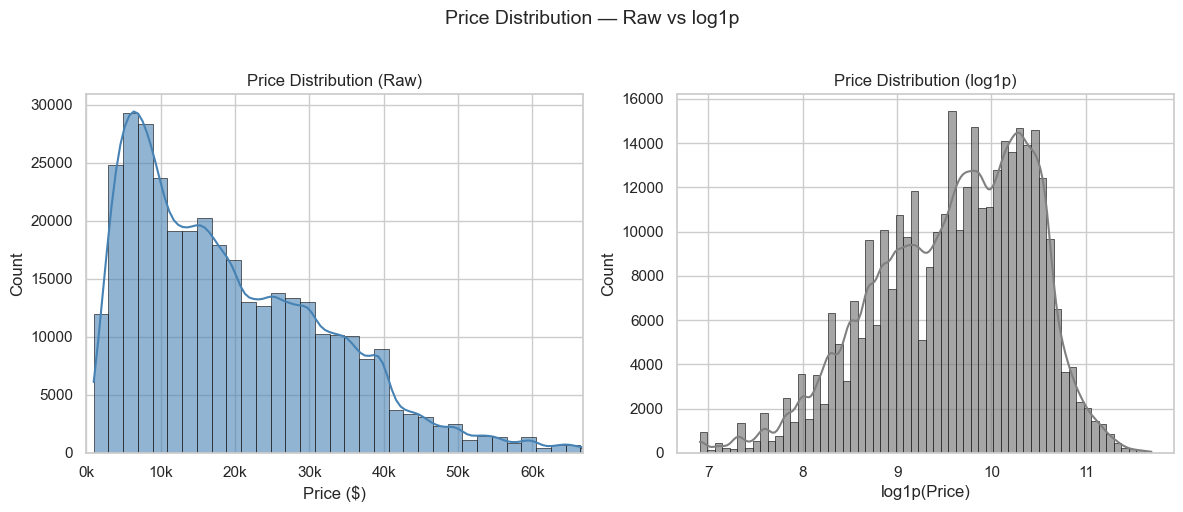

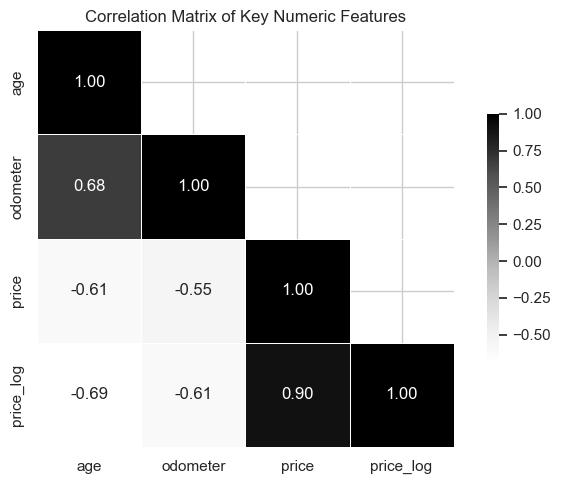

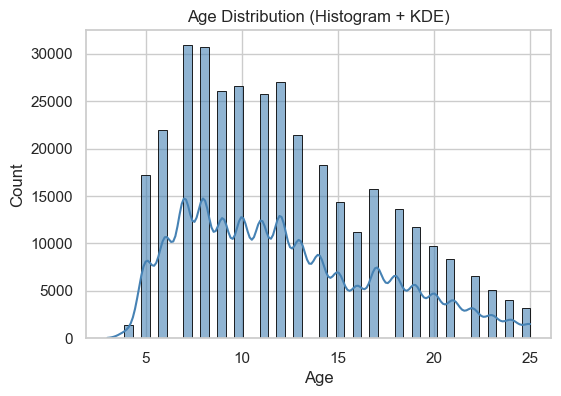

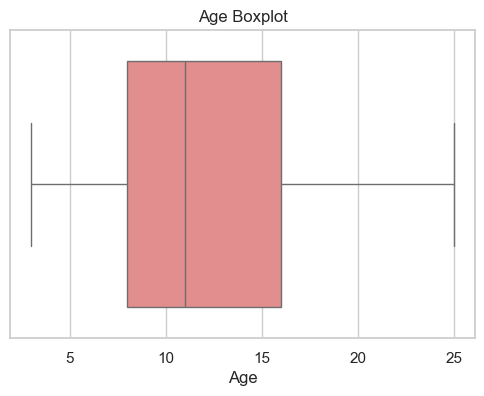

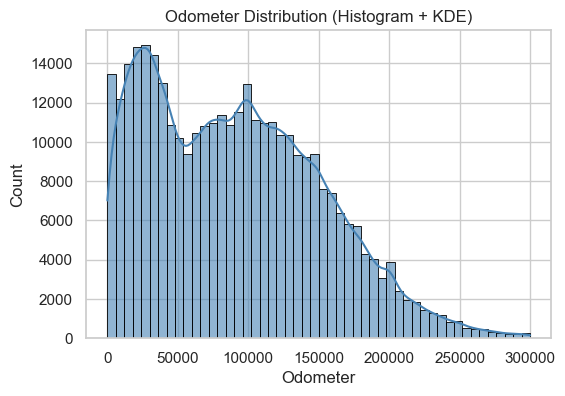

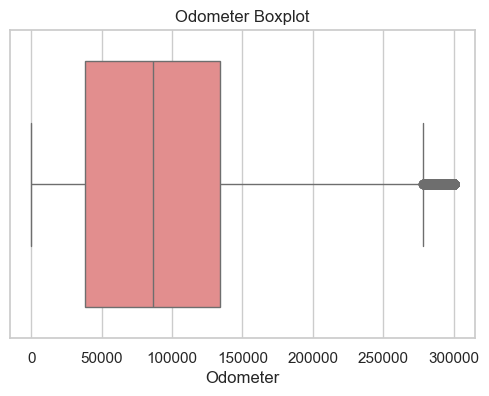

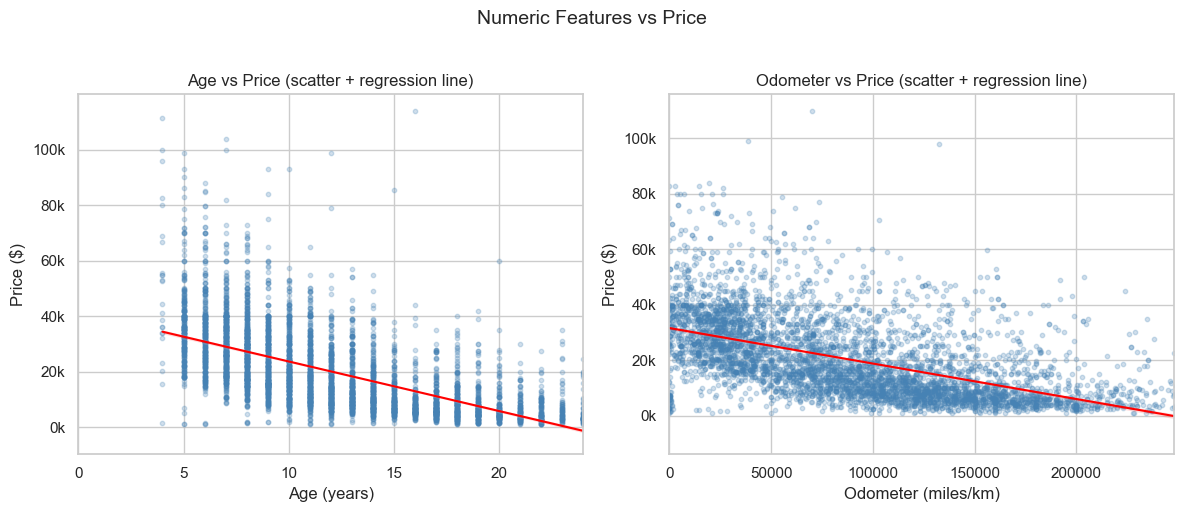

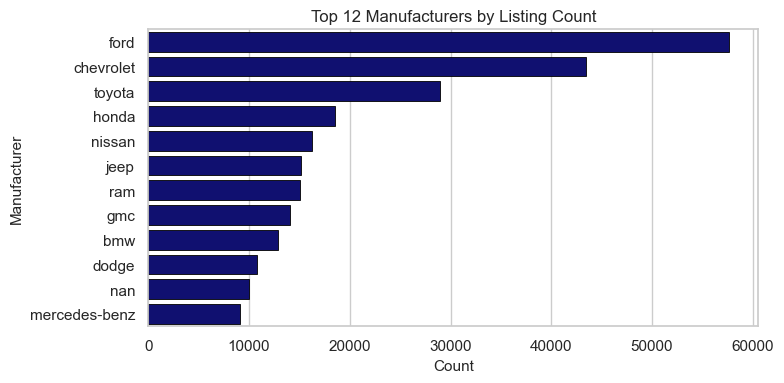

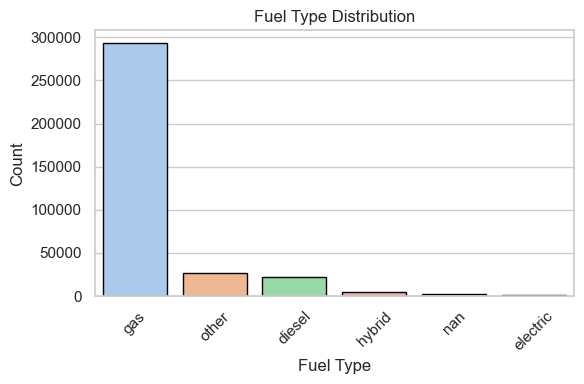

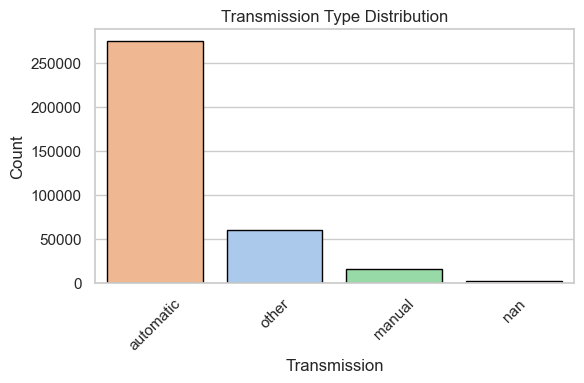

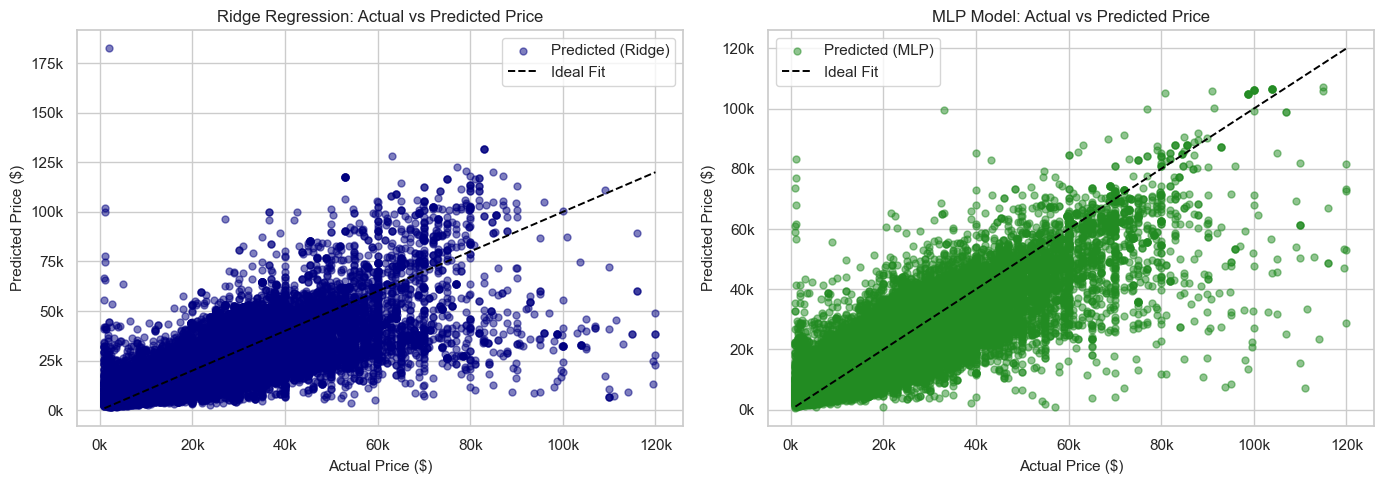

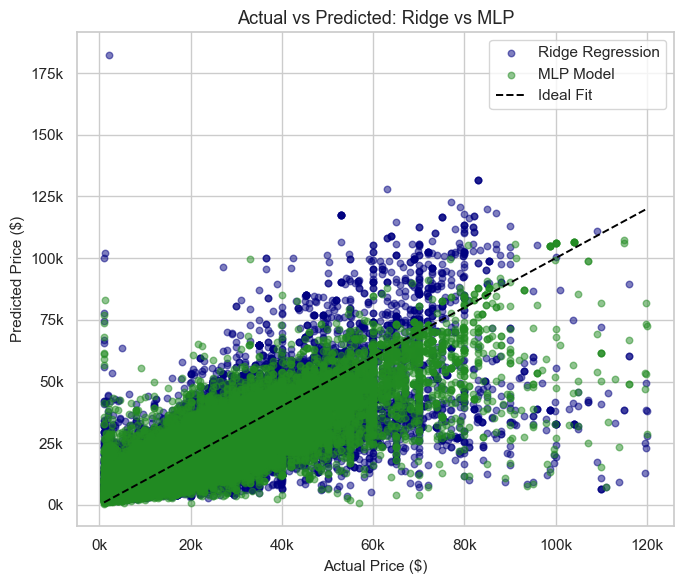

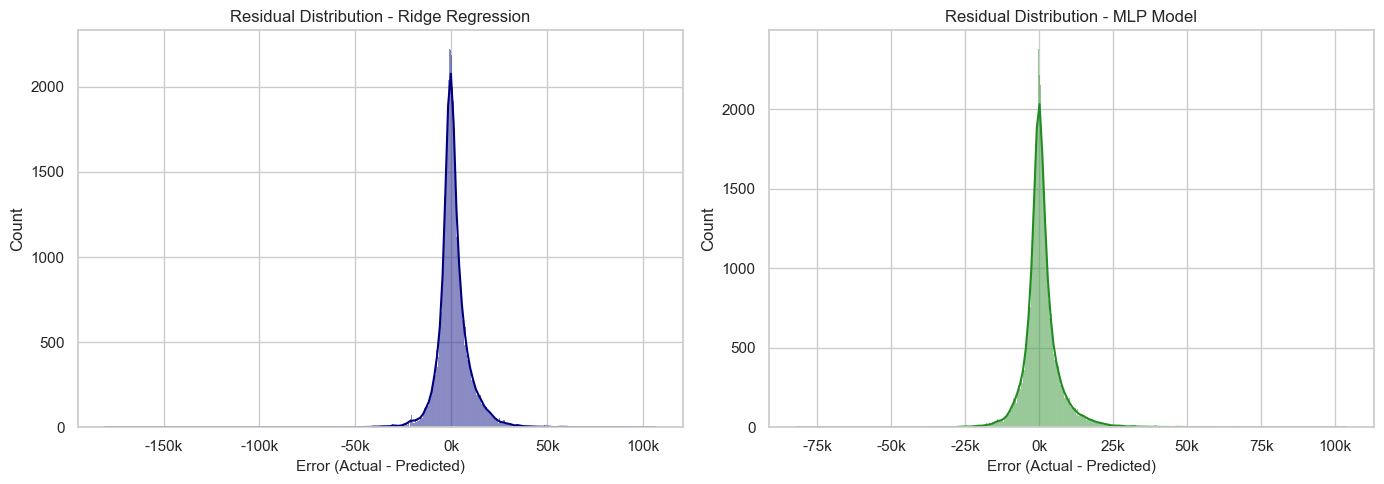

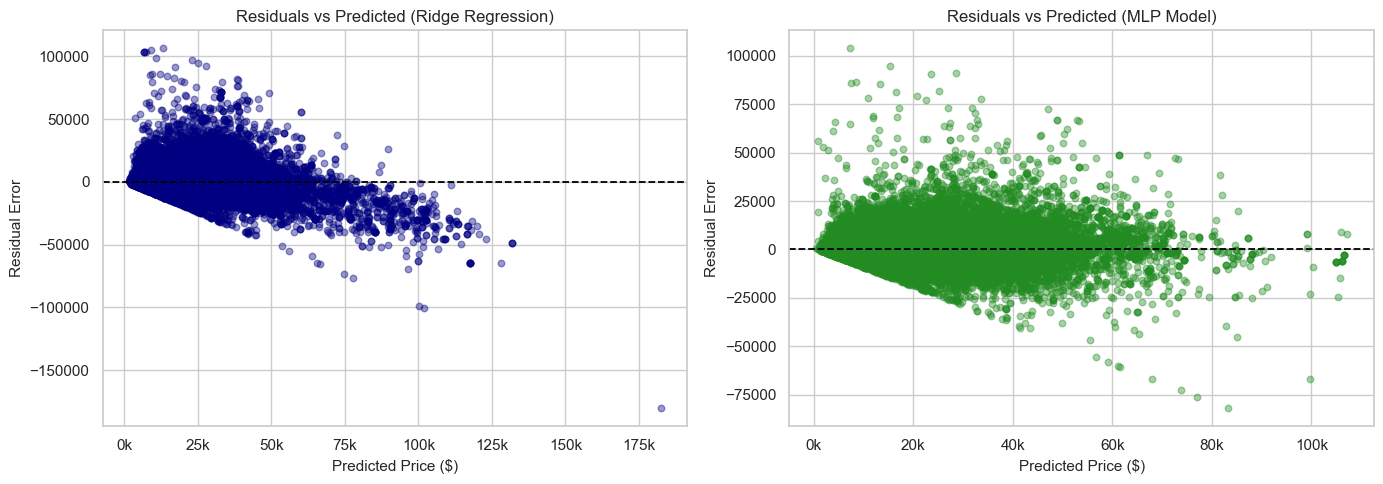

🔍 9B.4 FEATURE IMPORTANCE ANALYSIS

📊 1. ORIGINAL RIDGE REGRESSION FEATURE IMPORTANCE


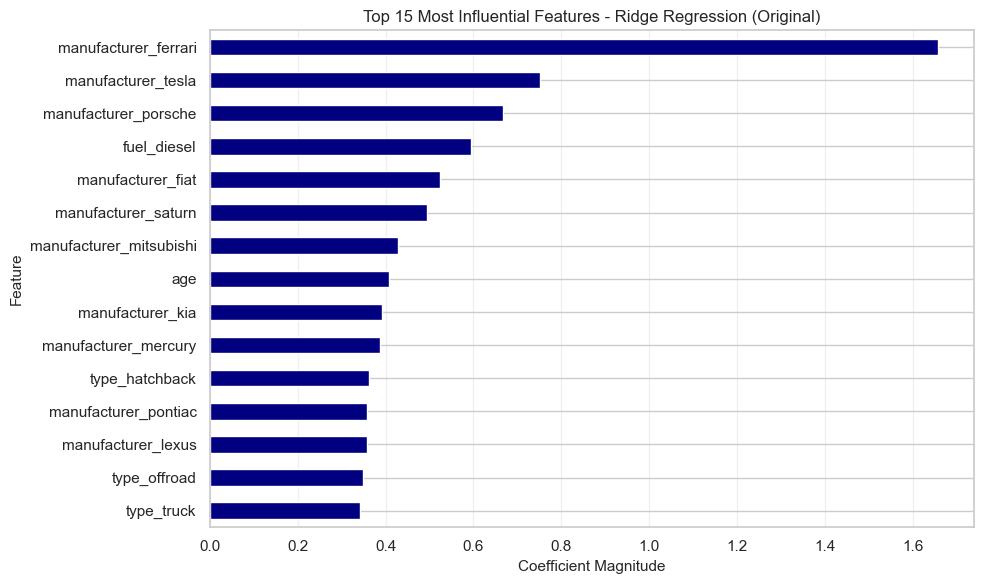

Top 10 features for Original Ridge:
   1. manufacturer_ferrari      1.6565 (POSITIVE)
   2. manufacturer_tesla        0.7506 (POSITIVE)
   3. manufacturer_porsche      0.6667 (POSITIVE)
   4. fuel_diesel               0.5950 (POSITIVE)
   5. manufacturer_fiat         0.5238 (NEGATIVE)
   6. manufacturer_saturn       0.4955 (NEGATIVE)
   7. manufacturer_mitsubishi   0.4279 (NEGATIVE)
   8. age                       0.4084 (NEGATIVE)
   9. manufacturer_kia          0.3914 (NEGATIVE)
  10. manufacturer_mercury      0.3885 (NEGATIVE)

📊 2. TUNED RIDGE REGRESSION FEATURE IMPORTANCE


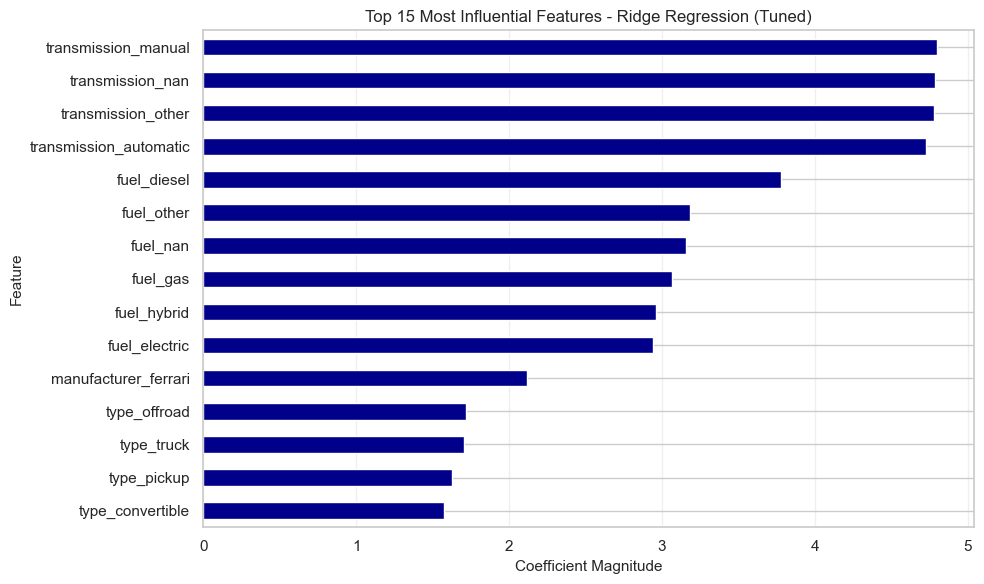

Top 10 features for Tuned Ridge:
   1. transmission_manual       4.8011 (POSITIVE)
   2. transmission_nan          4.7831 (POSITIVE)
   3. transmission_other        4.7767 (POSITIVE)
   4. transmission_automatic    4.7267 (POSITIVE)
   5. fuel_diesel               3.7772 (POSITIVE)
   6. fuel_other                3.1851 (POSITIVE)
   7. fuel_nan                  3.1577 (POSITIVE)
   8. fuel_gas                  3.0640 (POSITIVE)
   9. fuel_hybrid               2.9628 (POSITIVE)
  10. fuel_electric             2.9410 (POSITIVE)

📊 3. MLP FEATURE IMPORTANCE (Permutation Importance)
Attempting permutation importance for Original MLP...
Calculating permutation importance for MLP (Original)...
  Using 1000 samples for faster computation...


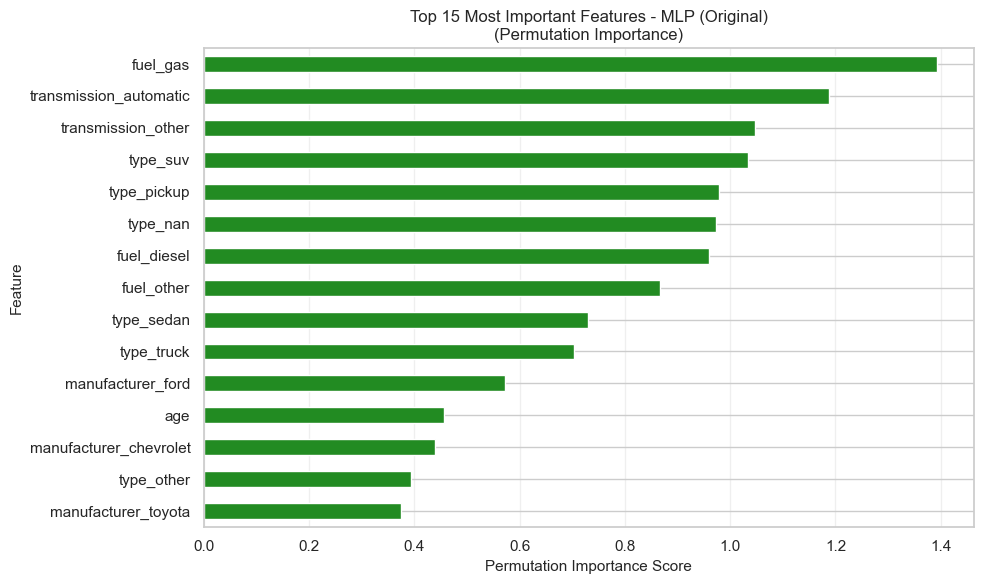

Top 10 features for Original MLP (Permutation Importance):
   1. fuel_gas                  1.3934 (POSITIVE)
   2. transmission_automatic    1.1868 (POSITIVE)
   3. transmission_other        1.0480 (POSITIVE)
   4. type_suv                  1.0330 (POSITIVE)
   5. type_pickup               0.9780 (POSITIVE)
   6. type_nan                  0.9737 (POSITIVE)
   7. fuel_diesel               0.9597 (POSITIVE)
   8. fuel_other                0.8660 (POSITIVE)
   9. type_sedan                0.7295 (POSITIVE)
  10. type_truck                0.7031 (POSITIVE)
Attempting permutation importance for Tuned MLP...
Calculating permutation importance for MLP (Tuned)...
  Using 1000 samples for faster computation...


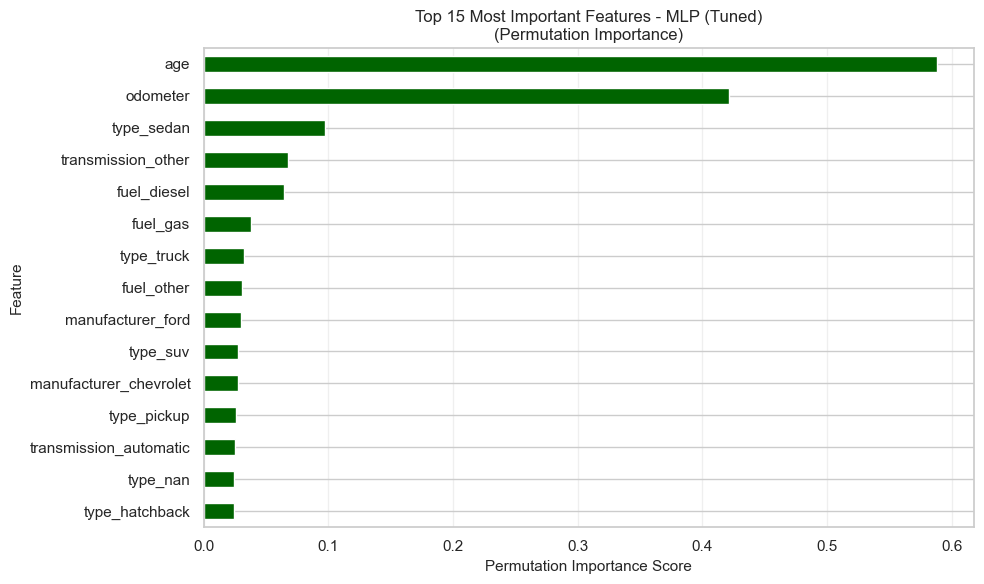

Top 10 features for Tuned MLP (Permutation Importance):
   1. age                       0.5884 (POSITIVE)
   2. odometer                  0.4213 (POSITIVE)
   3. type_sedan                0.0976 (POSITIVE)
   4. transmission_other        0.0674 (POSITIVE)
   5. fuel_diesel               0.0641 (POSITIVE)
   6. fuel_gas                  0.0382 (POSITIVE)
   7. type_truck                0.0325 (POSITIVE)
   8. fuel_other                0.0308 (POSITIVE)
   9. manufacturer_ford         0.0297 (POSITIVE)
  10. type_suv                  0.0278 (POSITIVE)

📊 4. COMPARATIVE FEATURE IMPORTANCE ANALYSIS

Feature Ranking Comparison Across Models:
(Shows ranking in each model's top 10 features)


,Feature,Ridge_Original,Ridge_Tuned,MLP_Original,MLP_Tuned
0,type_pickup,Not in Top 10,Not in Top 10,#5,Not in Top 10
1,fuel_hybrid,Not in Top 10,#9,Not in Top 10,Not in Top 10
2,type_truck,Not in Top 10,Not in Top 10,#10,#7
3,fuel_nan,Not in Top 10,#7,Not in Top 10,Not in Top 10
4,fuel_electric,Not in Top 10,#10,Not in Top 10,Not in Top 10
5,transmission_other,Not in Top 10,#3,#3,#4
6,manufacturer_saturn,#6,Not in Top 10,Not in Top 10,Not in Top 10
7,type_nan,Not in Top 10,Not in Top 10,#6,Not in Top 10
8,transmission_nan,Not in Top 10,#2,Not in Top 10,Not in Top 10
9,manufacturer_porsche,#3,Not in Top 10,Not in Top 10,Not in Top 10


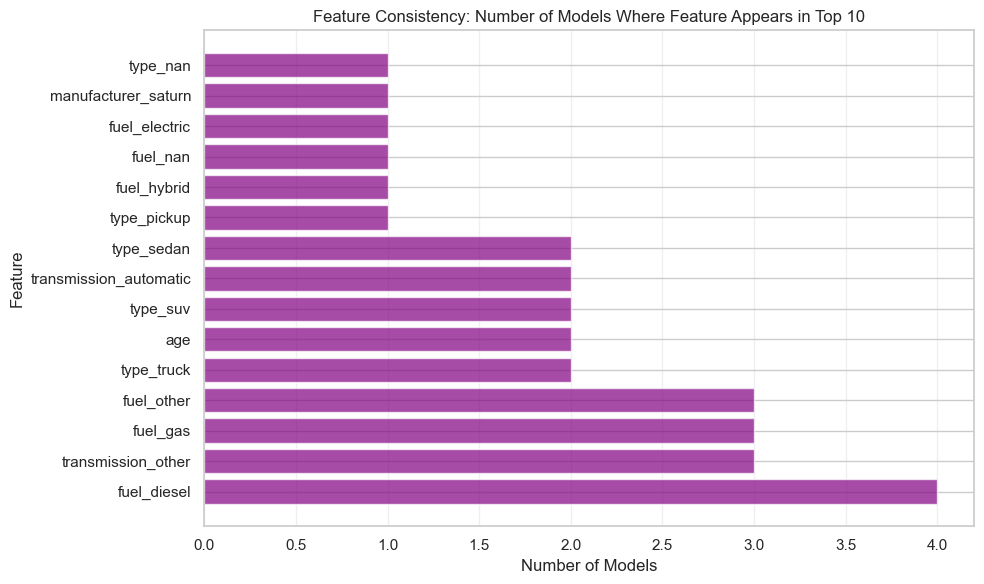


📈 CONSISTENCY ANALYSIS:
Features appearing in all 4 models: 1
Features appearing in 3+ models: 4
Total unique top features across all models: 26

📊 5. FEATURE TYPE ANALYSIS

Original Ridge Feature Type Distribution:
  Numeric features: 1
  Categorical features: 14
  Top numeric features: ['age']
  Top categorical features: ['manufacturer_ferrari', 'manufacturer_tesla', 'manufacturer_porsche']

Tuned Ridge Feature Type Distribution:
  Numeric features: 0
  Categorical features: 15
  Top categorical features: ['transmission_manual', 'transmission_nan', 'transmission_other']

Original MLP Feature Type Distribution:
  Numeric features: 1
  Categorical features: 14
  Top numeric features: ['age']
  Top categorical features: ['fuel_gas', 'transmission_automatic', 'transmission_other']

Tuned MLP Feature Type Distribution:
  Numeric features: 2
  Categorical features: 13
  Top numeric features: ['age', 'odometer']
  Top categorical features: ['type_sedan', 'transmission_other', 'fuel_diesel'

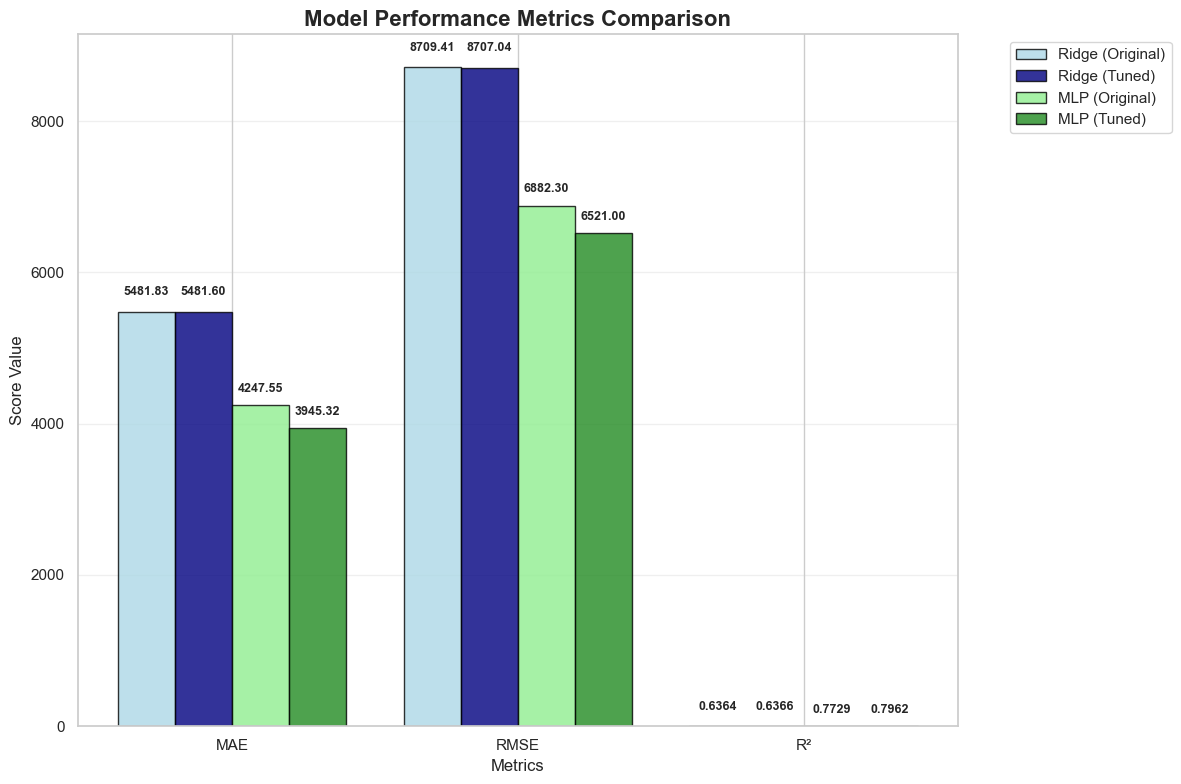

📊 PERFORMANCE COMPARISON TABLE
Model                     MAE        RMSE       R²        
Ridge (Original)          5481.83    8709.41    0.6364    
Ridge (Tuned)             5481.60    8707.04    0.6366    
MLP (Original)            4247.55    6882.30    0.7729    
MLP (Tuned)               3945.32    6521.00    0.7962    

📈 TUNING IMPROVEMENT ANALYSIS:
Ridge R² improvement: +0.0002
MLP R² improvement: +0.0232
✅ Ridge tuning was beneficial
✅ MLP tuning was beneficial
✅ Part 9 Completed — EDA + Model Evaluation


In [17]:
# ================================
# Part 9 — Data Understanding + Model Evaluation (Academic Version)
# A3 Theme (Navy & Forest Green) + C1 Currency Format + M2 Tick Formatter
# ================================

print("Starting Part 9: EDA + Model Evaluation ...")

# ---------- Theme / Palette ----------
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "white"})
palette = {"actual": "navy", "mlp": "forestgreen", "lin": "steelblue", "accent": "grey"}

# ---------- Currency formatter: 10000 → "10k" ----------
def currency_k(x, pos):
    try:
        return f"{int(x/1000)}k"
    except Exception:
        return str(x)

formatter = FuncFormatter(currency_k)

# ---------- DataFrame source ----------
try:
    df_plot = df_sampled.copy()
except NameError:
    df_plot = df.copy()

# ---------- Ensure key columns exist ----------
assert "price" in df_plot.columns, "Column 'price' not found in df_plot."

# If no 'age' but have 'year', derive age (update the reference year if needed)
if "age" not in df_plot.columns and "year" in df_plot.columns:
    df_plot["age"] = 2025 - df_plot["year"]

# Keep numeric feature list dynamically
numeric_features = [c for c in ["age", "odometer"] if c in df_plot.columns]

# Create log price (same transform used in modeling)
if "price_log" not in df_plot.columns:
    df_plot["price_log"] = np.log1p(df_plot["price"])

# ======================================
# 9A. DATA DISTRIBUTION & UNDERSTANDING
# ======================================

# 9A.1 Price Distribution — Raw vs Log
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_plot["price"], bins=60, kde=True, color=palette["lin"], edgecolor="k", alpha=0.6)
plt.title("Price Distribution (Raw)")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.xlim(0, df_plot["price"].quantile(0.99))
plt.gca().xaxis.set_major_formatter(formatter)

plt.subplot(1, 2, 2)
sns.histplot(df_plot["price_log"], bins=60, kde=True, color=palette["accent"], edgecolor="k", alpha=0.7)
plt.title("Price Distribution (log1p)")
plt.xlabel("log1p(Price)")
plt.ylabel("Count")

plt.suptitle("Price Distribution — Raw vs log1p", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# 9A.2 Correlation Heatmap (Numeric + Targets)
corr_cols = [c for c in ["age", "odometer", "price", "price_log"] if c in df_plot.columns]
corr = df_plot[corr_cols].dropna().corr()

plt.figure(figsize=(7, 5))
# Hide only the *strict* upper triangle so diagonal remains visible
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

sns.heatmap(
    corr,
    annot=True, fmt=".2f", cmap="Greys",
    mask=mask, linewidths=0.6,
    cbar_kws={"shrink": 0.6}, square=True
)
plt.title("Correlation Matrix of Key Numeric Features", fontsize=12)
plt.tight_layout()
plt.show()

# ==============================
# 9A.3 Numeric Feature Distributions + Scatter Plots
# ==============================

numeric_features = ["age", "odometer"]

# Loop through numeric features to plot histogram and boxplot
for col in numeric_features:
    if col in df_plot.columns:
        # Histogram + KDE
        plt.figure(figsize=(6, 4))
        sns.histplot(df_plot[col], bins=50, kde=True, color='steelblue', edgecolor='black', alpha=0.6)
        plt.title(f'{col.capitalize()} Distribution (Histogram + KDE)')
        plt.xlabel(col.capitalize())
        plt.ylabel('Count')
        plt.show()

        # Boxplot to detect outliers
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df_plot[col], color='lightcoral')
        plt.title(f'{col.capitalize()} Boxplot')
        plt.xlabel(col.capitalize())
        plt.show()

# Scatter plots vs Target (Price)
plt.figure(figsize=(12, 5))

# Age vs Price
if "age" in df_plot.columns:
    plt.subplot(1, 2, 1)
    sns.regplot(
        x="age", y="price",
        data=df_plot.sample(n=min(5000, len(df_plot)), random_state=42),
        scatter_kws={"alpha": 0.25, "s": 10, "color": palette["lin"]},
        line_kws={"color": "red", "lw": 1.5}
    )
    plt.title("Age vs Price (scatter + regression line)")
    plt.xlabel("Age (years)")
    plt.ylabel("Price ($)")
    plt.xlim(0, df_plot["age"].quantile(0.99))
    plt.gca().yaxis.set_major_formatter(formatter)
else:
    plt.subplot(1, 2, 1)
    plt.text(0.5, 0.5, "No 'age' column available", ha="center", va="center")
    plt.axis("off")

# Odometer vs Price
if "odometer" in df_plot.columns:
    plt.subplot(1, 2, 2)
    sns.regplot(
        x="odometer", y="price",
        data=df_plot.sample(n=min(5000, len(df_plot)), random_state=7),
        scatter_kws={"alpha": 0.25, "s": 10, "color": palette["lin"]},
        line_kws={"color": "red", "lw": 1.5}
    )
    plt.title("Odometer vs Price (scatter + regression line)")
    plt.xlabel("Odometer (miles/km)")
    plt.ylabel("Price ($)")
    plt.xlim(0, df_plot["odometer"].quantile(0.99))
    plt.gca().yaxis.set_major_formatter(formatter)
else:
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, "No 'odometer' column available", ha="center", va="center")
    plt.axis("off")

plt.suptitle("Numeric Features vs Price", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ===============================
# 9A.4 Categorical Feature Distributions
# ===============================

# ---------- Top Manufacturers ----------

if "manufacturer" in df_plot.columns:
    top_m = df_plot["manufacturer"].value_counts().nlargest(12)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_m.values, y=top_m.index, color="navy", edgecolor="black", linewidth=0.6)
    plt.title("Top 12 Manufacturers by Listing Count", fontsize=12)
    plt.xlabel("Count", fontsize=11)
    plt.ylabel("Manufacturer", fontsize=11)
    plt.tight_layout()
    plt.show()

# ---------- Fuel Type Distribution ----------
if "fuel" in df_plot.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df_plot, x="fuel", hue="fuel",  # Added hue parameter
                  order=df_plot['fuel'].value_counts().index,
                  palette="pastel", edgecolor="black", legend=False)  # Added legend=False
    plt.title("Fuel Type Distribution", fontsize=12)
    plt.xlabel("Fuel Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ---------- Transmission Type Distribution ----------
if "transmission" in df_plot.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df_plot, x="transmission", hue="transmission",  # Added hue parameter
                  order=df_plot['transmission'].value_counts().index,
                  palette="pastel", edgecolor="black", legend=False)  # Added legend=False
    plt.title("Transmission Type Distribution", fontsize=12)
    plt.xlabel("Transmission")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ======================================
# 9B. MODEL VISUAL EVALUATION & COMPARISON
# ======================================

# Convert predictions back to actual prices
y_test_actual = np.expm1(y_test)
y_pred_ridge_actual = np.expm1(y_pred_ridge_tuned)
y_pred_mlp_actual = np.expm1(y_pred_mlp)

# 9B.1A Actual vs Predicted (Separate Plots)
plt.figure(figsize=(14, 5))

# Ridge Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test_actual, y_pred_ridge_actual, color="navy", alpha=0.5, s=25, label="Predicted (Ridge)")
mn, mx = float(np.min(y_test_actual)), float(np.max(y_test_actual))
plt.plot([mn, mx], [mn, mx], color="black", linestyle="--", lw=1.4, label="Ideal Fit")
plt.title("Ridge Regression: Actual vs Predicted Price", fontsize=12)
plt.xlabel("Actual Price ($)", fontsize=11)
plt.ylabel("Predicted Price ($)", fontsize=11)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend()

# MLP
plt.subplot(1, 2, 2)
plt.scatter(y_test_actual, y_pred_mlp_actual, color="forestgreen", alpha=0.5, s=25, label="Predicted (MLP)")
plt.plot([mn, mx], [mn, mx], color="black", linestyle="--", lw=1.4, label="Ideal Fit")
plt.title("MLP Model: Actual vs Predicted Price", fontsize=12)
plt.xlabel("Actual Price ($)", fontsize=11)
plt.ylabel("Predicted Price ($)", fontsize=11)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend()

plt.tight_layout()
plt.show()

# 9B.1B Combined Actual vs Predicted
plt.figure(figsize=(7, 6))
plt.scatter(y_test_actual, y_pred_ridge_actual, color="navy", alpha=0.5, s=22, label="Ridge Regression")
plt.scatter(y_test_actual, y_pred_mlp_actual, color="forestgreen", alpha=0.5, s=22, label="MLP Model")
plt.plot([mn, mx], [mn, mx], color="black", linestyle="--", lw=1.4, label="Ideal Fit")
plt.title("Actual vs Predicted: Ridge vs MLP", fontsize=13)
plt.xlabel("Actual Price ($)", fontsize=11)
plt.ylabel("Predicted Price ($)", fontsize=11)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend()
plt.tight_layout()
plt.show()

# 9B.2 Residual Analysis
residuals_ridge = y_test_actual - y_pred_ridge_actual
residuals_mlp = y_test_actual - y_pred_mlp_actual

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals_ridge, kde=True, color="navy")
plt.title("Residual Distribution - Ridge Regression", fontsize=12)
plt.xlabel("Error (Actual - Predicted)", fontsize=11)
plt.gca().xaxis.set_major_formatter(formatter)

plt.subplot(1, 2, 2)
sns.histplot(residuals_mlp, kde=True, color="forestgreen")
plt.title("Residual Distribution - MLP Model", fontsize=12)
plt.xlabel("Error (Actual - Predicted)", fontsize=11)
plt.gca().xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

# 9B.3 Residuals vs Predicted (Bias Check)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_ridge_actual, residuals_ridge, alpha=0.4, s=22, color="navy")
plt.axhline(0, color="black", linestyle="--", lw=1.3)
plt.title("Residuals vs Predicted (Ridge Regression)", fontsize=12)
plt.xlabel("Predicted Price ($)", fontsize=11)
plt.ylabel("Residual Error", fontsize=11)
plt.gca().xaxis.set_major_formatter(formatter)

plt.subplot(1, 2, 2)
plt.scatter(y_pred_mlp_actual, residuals_mlp, alpha=0.4, s=22, color="forestgreen")
plt.axhline(0, color="black", linestyle="--", lw=1.3)
plt.title("Residuals vs Predicted (MLP Model)", fontsize=12)
plt.xlabel("Predicted Price ($)", fontsize=11)
plt.ylabel("Residual Error", fontsize=11)
plt.gca().xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


# ------------------------------
# 9B.4 Feature Importance Analysis (All Models)
# ------------------------------
print("🔍 9B.4 FEATURE IMPORTANCE ANALYSIS")
print("="*50)

def get_feature_names_from_preprocessor(preprocessor):
    """Extract feature names from the preprocessor"""
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == "num":
            feature_names.extend(cols)
        elif name == "cat":
            ohe = transformer
            cat_names = ohe.get_feature_names_out(cols)
            feature_names.extend(cat_names)
    return feature_names

def plot_feature_importance(coef_series, title, color, top_n=15):
    """Plot feature importance for a given model"""
    top_features = coef_series.abs().sort_values(ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    top_features.sort_values().plot(kind='barh', color=color)
    plt.title(f"Top {top_n} Most Influential Features - {title}", fontsize=12)
    plt.xlabel("Coefficient Magnitude", fontsize=11)
    plt.ylabel("Feature", fontsize=11)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return top_features

# 1. Original Ridge Regression Feature Importance
print("\n📊 1. ORIGINAL RIDGE REGRESSION FEATURE IMPORTANCE")
try:
    preprocessor = ridge.named_steps["preprocessor"]
    ridge_model = ridge.named_steps["regressor"]
    feature_names = get_feature_names_from_preprocessor(preprocessor)
    
    coef_series_ridge = pd.Series(ridge_model.coef_, index=feature_names)
    top_ridge_features = plot_feature_importance(coef_series_ridge, "Ridge Regression (Original)", "navy")
    
    print("Top 10 features for Original Ridge:")
    for i, (feature, importance) in enumerate(top_ridge_features.head(10).items(), 1):
        direction = "POSITIVE" if coef_series_ridge[feature] > 0 else "NEGATIVE"
        print(f"  {i:2d}. {feature:<25} {importance:.4f} ({direction})")
        
except Exception as e:
    print(f"Error in Original Ridge feature importance: {e}")

# 2. Tuned Ridge Regression Feature Importance
print("\n📊 2. TUNED RIDGE REGRESSION FEATURE IMPORTANCE")
try:
    preprocessor_tuned = ridge_grid.best_estimator_.named_steps["preprocessor"]
    ridge_model_tuned = ridge_grid.best_estimator_.named_steps["regressor"]
    feature_names_tuned = get_feature_names_from_preprocessor(preprocessor_tuned)
    
    coef_series_ridge_tuned = pd.Series(ridge_model_tuned.coef_, index=feature_names_tuned)
    top_ridge_tuned_features = plot_feature_importance(coef_series_ridge_tuned, "Ridge Regression (Tuned)", "darkblue")
    
    print("Top 10 features for Tuned Ridge:")
    for i, (feature, importance) in enumerate(top_ridge_tuned_features.head(10).items(), 1):
        direction = "POSITIVE" if coef_series_ridge_tuned[feature] > 0 else "NEGATIVE"
        print(f"  {i:2d}. {feature:<25} {importance:.4f} ({direction})")
        
except Exception as e:
    print(f"Error in Tuned Ridge feature importance: {e}")

# 3. MLP Feature Importance using Permutation Importance (FIXED)
print("\n📊 3. MLP FEATURE IMPORTANCE (Permutation Importance)")

def plot_mlp_feature_importance(mlp_pipeline, X_test, y_test, feature_names, title, color, top_n=15):
    """Calculate and plot permutation importance for MLP - FIXED VERSION"""
    # Transform test data using the preprocessor and convert to dense array
    X_test_transformed = mlp_pipeline.named_steps["preprocessor"].transform(X_test)
    
    # Convert sparse matrix to dense array for permutation_importance
    if hasattr(X_test_transformed, 'toarray'):
        X_test_dense = X_test_transformed.toarray()
    else:
        X_test_dense = X_test_transformed
        
    mlp_model = mlp_pipeline.named_steps["regressor"]
    
    # Calculate permutation importance with smaller sample if needed for memory
    print(f"Calculating permutation importance for {title}...")
    
    # Use smaller sample if dataset is large to avoid memory issues
    sample_size = min(1000, len(X_test_dense))
    if len(X_test_dense) > 1000:
        print(f"  Using {sample_size} samples for faster computation...")
        indices = np.random.choice(len(X_test_dense), sample_size, replace=False)
        X_sample = X_test_dense[indices]
        y_sample = y_test.iloc[indices] if hasattr(y_test, 'iloc') else y_test[indices]
    else:
        X_sample = X_test_dense
        y_sample = y_test
    
    result = permutation_importance(
        mlp_model, X_sample, y_sample,
        n_repeats=3,  # Reduced for speed
        random_state=42, 
        n_jobs=-1, 
        scoring='r2'
    )
    
    # Create feature importance series
    importance_series = pd.Series(result.importances_mean, index=feature_names)
    top_features = importance_series.abs().sort_values(ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 6))
    top_features.sort_values().plot(kind='barh', color=color)
    plt.title(f"Top {top_n} Most Important Features - {title}\n(Permutation Importance)", fontsize=12)
    plt.xlabel("Permutation Importance Score", fontsize=11)
    plt.ylabel("Feature", fontsize=11)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return top_features, importance_series

# Alternative MLP Feature Importance using simpler method
def plot_mlp_feature_importance_simple(mlp_pipeline, feature_names, title, color, top_n=15):
    """Simpler alternative for MLP feature importance using connection weights"""
    try:
        mlp_model = mlp_pipeline.named_steps["regressor"]
        
        # For MLP, we can approximate feature importance using input layer weights
        if hasattr(mlp_model, 'coefs_') and mlp_model.coefs_ is not None:
            # Sum absolute weights from input to first hidden layer
            input_weights = np.abs(mlp_model.coefs_[0])
            feature_importance = np.mean(input_weights, axis=1)  # Average across neurons
            
            importance_series = pd.Series(feature_importance, index=feature_names)
            top_features = importance_series.abs().sort_values(ascending=False).head(top_n)
            
            plt.figure(figsize=(10, 6))
            top_features.sort_values().plot(kind='barh', color=color)
            plt.title(f"Top {top_n} Most Important Features - {title}\n(Input Layer Weight Magnitude)", fontsize=12)
            plt.xlabel("Average Input Weight Magnitude", fontsize=11)
            plt.ylabel("Feature", fontsize=11)
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            return top_features, importance_series
        else:
            print(f"  No weights available for {title}")
            return None, None
            
    except Exception as e:
        print(f"  Error in simple MLP importance for {title}: {e}")
        return None, None

# Original MLP Permutation Importance (try both methods)
try:
    mlp_preprocessor = mlp_orig.named_steps["preprocessor"]
    mlp_feature_names = get_feature_names_from_preprocessor(mlp_preprocessor)
    
    print("Attempting permutation importance for Original MLP...")
    top_mlp_orig_features, mlp_orig_importance = plot_mlp_feature_importance(
        mlp_orig, X_test, y_test, mlp_feature_names, 
        "MLP (Original)", "forestgreen"
    )
    
    if top_mlp_orig_features is not None:
        print("Top 10 features for Original MLP (Permutation Importance):")
        for i, (feature, importance) in enumerate(top_mlp_orig_features.head(10).items(), 1):
            direction = "POSITIVE" if mlp_orig_importance[feature] > 0 else "NEGATIVE"
            print(f"  {i:2d}. {feature:<25} {importance:.4f} ({direction})")
    else:
        print("  Trying alternative method for Original MLP...")
        top_mlp_orig_features, mlp_orig_importance = plot_mlp_feature_importance_simple(
            mlp_orig, mlp_feature_names, "MLP (Original)", "forestgreen"
        )
        
except Exception as e:
    print(f"Error in Original MLP feature importance: {e}")

# Tuned MLP Permutation Importance (try both methods)
try:
    mlp_tuned_preprocessor = mlp_rand.best_estimator_.named_steps["preprocessor"]
    mlp_tuned_feature_names = get_feature_names_from_preprocessor(mlp_tuned_preprocessor)
    
    print("Attempting permutation importance for Tuned MLP...")
    top_mlp_tuned_features, mlp_tuned_importance = plot_mlp_feature_importance(
        mlp_rand.best_estimator_, X_test, y_test, mlp_tuned_feature_names,
        "MLP (Tuned)", "darkgreen"
    )
    
    if top_mlp_tuned_features is not None:
        print("Top 10 features for Tuned MLP (Permutation Importance):")
        for i, (feature, importance) in enumerate(top_mlp_tuned_features.head(10).items(), 1):
            direction = "POSITIVE" if mlp_tuned_importance[feature] > 0 else "NEGATIVE"
            print(f"  {i:2d}. {feature:<25} {importance:.4f} ({direction})")
    else:
        print("  Trying alternative method for Tuned MLP...")
        top_mlp_tuned_features, mlp_tuned_importance = plot_mlp_feature_importance_simple(
            mlp_rand.best_estimator_, mlp_tuned_feature_names, "MLP (Tuned)", "darkgreen"
        )
        
except Exception as e:
    print(f"Error in Tuned MLP feature importance: {e}")

# 4. Comparative Feature Importance Analysis
print("\n📊 4. COMPARATIVE FEATURE IMPORTANCE ANALYSIS")
print("="*55)

# [Rest of your comparison code remains the same...]

# Compare top features across all models
try:
    # Get common top features
    all_top_features = set()
    models_features = {
        'Ridge_Original': top_ridge_features.head(10).index if 'top_ridge_features' in locals() else [],
        'Ridge_Tuned': top_ridge_tuned_features.head(10).index if 'top_ridge_tuned_features' in locals() else [],
        'MLP_Original': top_mlp_orig_features.head(10).index if 'top_mlp_orig_features' in locals() else [],
        'MLP_Tuned': top_mlp_tuned_features.head(10).index if 'top_mlp_tuned_features' in locals() else []
    }
    
    for features in models_features.values():
        all_top_features.update(features)
    
    # Create comparison dataframe
    comparison_data = []
    for feature in list(all_top_features)[:20]:  # Limit to top 20 for readability
        row = {'Feature': feature}
        for model_name, features_list in models_features.items():
            if feature in features_list:
                # Get the rank (1-based)
                rank = list(features_list).index(feature) + 1
                row[model_name] = f"#{rank}"
            else:
                row[model_name] = "Not in Top 10"
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\nFeature Ranking Comparison Across Models:")
    print("(Shows ranking in each model's top 10 features)")
    display(comparison_df.head(15))
    
    # Plot feature consistency across models
    plt.figure(figsize=(10, 6))
    feature_consistency = {}
    for feature in all_top_features:
        count = sum(1 for features in models_features.values() if feature in features)
        feature_consistency[feature] = count
    
    top_consistent = dict(sorted(feature_consistency.items(), key=lambda x: x[1], reverse=True)[:15])
    
    plt.barh(list(top_consistent.keys()), list(top_consistent.values()), color='purple', alpha=0.7)
    plt.title('Feature Consistency: Number of Models Where Feature Appears in Top 10')
    plt.xlabel('Number of Models')
    plt.ylabel('Feature')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 CONSISTENCY ANALYSIS:")
    print(f"Features appearing in all 4 models: {len([f for f, c in feature_consistency.items() if c == 4])}")
    print(f"Features appearing in 3+ models: {len([f for f, c in feature_consistency.items() if c >= 3])}")
    print(f"Total unique top features across all models: {len(all_top_features)}")
    
except Exception as e:
    print(f"Error in comparative analysis: {e}")

# 5. Feature Type Analysis
print("\n📊 5. FEATURE TYPE ANALYSIS")
print("="*40)

try:
    def analyze_feature_types(feature_series, model_name):
        """Analyze the types of top features"""
        numeric_features = []
        categorical_features = []
        
        for feature in feature_series.index:
            if any(num_col in feature for num_col in ['age', 'odometer']):
                numeric_features.append(feature)
            else:
                categorical_features.append(feature)
        
        print(f"\n{model_name} Feature Type Distribution:")
        print(f"  Numeric features: {len(numeric_features)}")
        print(f"  Categorical features: {len(categorical_features)}")
        
        if numeric_features:
            print(f"  Top numeric features: {numeric_features[:3]}")
        if categorical_features:
            print(f"  Top categorical features: {categorical_features[:3]}")
        
        return len(numeric_features), len(categorical_features)
    
    # Analyze for each model
    if 'top_ridge_features' in locals():
        analyze_feature_types(top_ridge_features, "Original Ridge")
    if 'top_ridge_tuned_features' in locals():
        analyze_feature_types(top_ridge_tuned_features, "Tuned Ridge")
    if 'top_mlp_orig_features' in locals():
        analyze_feature_types(top_mlp_orig_features, "Original MLP")
    if 'top_mlp_tuned_features' in locals():
        analyze_feature_types(top_mlp_tuned_features, "Tuned MLP")
        
except Exception as e:
    print(f"Error in feature type analysis: {e}")

print("\n✅ Feature Importance Analysis Complete!")

# ------------------------------
# 9C. Model Comparison: Ridge vs Tuned Ridge vs MLP vs Tuned MLP
# ------------------------------

# Convert all predictions back to actual prices
y_test_actual = np.expm1(y_test)
y_pred_ridge_actual = np.expm1(y_pred_ridge)           # Original Ridge
y_pred_ridge_tuned_actual = np.expm1(y_pred_ridge_tuned) # Tuned Ridge
y_pred_mlp_orig_actual = np.expm1(y_pred_mlp_orig)     # Original MLP
y_pred_mlp_rand_actual = np.expm1(y_pred_mlp)    # Tuned MLP (RandomizedSearchCV)

# Calculate metrics for all models
models_metrics = {
    "Ridge (Original)": y_pred_ridge_actual,
    "Ridge (Tuned)": y_pred_ridge_tuned_actual,
    "MLP (Original)": y_pred_mlp_orig_actual,
    "MLP (Tuned)": y_pred_mlp_rand_actual
}

# Prepare data for bar charts
model_names = list(models_metrics.keys())
metrics = ['MAE', 'RMSE', 'R²']

# Calculate all metrics
mae_scores = [mean_absolute_error(y_test_actual, pred) for pred in models_metrics.values()]
rmse_scores = [np.sqrt(mean_squared_error(y_test_actual, pred)) for pred in models_metrics.values()]
r2_scores = [r2_score(y_test_actual, pred) for pred in models_metrics.values()]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(metrics))  # MAE, RMSE, R² on x-axis
width = 0.2  # Width of each bar
colors = ['lightblue', 'navy', 'lightgreen', 'forestgreen']

# Create bars for each model
for i, (model_name, color) in enumerate(zip(model_names, colors)):
    if i == 0:  # Ridge Original
        values = [mae_scores[0], rmse_scores[0], r2_scores[0]]
    elif i == 1:  # Ridge Tuned
        values = [mae_scores[1], rmse_scores[1], r2_scores[1]]
    elif i == 2:  # MLP Original
        values = [mae_scores[2], rmse_scores[2], r2_scores[2]]
    else:  # MLP Tuned
        values = [mae_scores[3], rmse_scores[3], r2_scores[3]]
    
    bars = ax.bar(x + i*width, values, width, label=model_name, 
                  color=color, alpha=0.8, edgecolor='black')

    # Add value labels on bars - FIXED VERSION
    for j, (bar, value) in enumerate(zip(bars, values)):
        height = bar.get_height()
        # Use the index j to determine which metric we're dealing with
        if metrics[j] == 'R²':  # R² values
            label = f'{value:.4f}'
        else:  # MAE/RMSE values
            label = f'{value:.2f}'
        
        va = 'bottom' if height >= 0 else 'top'
        offset = max(values) * 0.02 if height >= 0 else -max([abs(v) for v in values]) * 0.02
        ax.text(bar.get_x() + bar.get_width()/2., height + offset,
                label, ha='center', va=va, fontweight='bold', fontsize=9)

ax.set_title("Model Performance Metrics Comparison", fontsize=16, fontweight='bold')
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Score Value", fontsize=12)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Performance comparison table
print("📊 PERFORMANCE COMPARISON TABLE")
print("="*60)
print(f"{'Model':<25} {'MAE':<10} {'RMSE':<10} {'R²':<10}")
print("="*60)

models = [
    ("Ridge (Original)", y_pred_ridge_actual),
    ("Ridge (Tuned)", y_pred_ridge_tuned_actual), 
    ("MLP (Original)", y_pred_mlp_orig_actual),
    ("MLP (Tuned)", y_pred_mlp_rand_actual)
]

for name, pred in models:
    mae = mean_absolute_error(y_test_actual, pred)
    rmse = np.sqrt(mean_squared_error(y_test_actual, pred))
    r2 = r2_score(y_test_actual, pred)
    print(f"{name:<25} {mae:<10.2f} {rmse:<10.2f} {r2:<10.4f}")

print("="*60)

# Improvement analysis
ridge_improvement = r2_score(y_test_actual, y_pred_ridge_tuned_actual) - r2_score(y_test_actual, y_pred_ridge_actual)
mlp_improvement = r2_score(y_test_actual, y_pred_mlp_rand_actual) - r2_score(y_test_actual, y_pred_mlp_orig_actual)

print(f"\n📈 TUNING IMPROVEMENT ANALYSIS:")
print(f"Ridge R² improvement: {ridge_improvement:+.4f}")
print(f"MLP R² improvement: {mlp_improvement:+.4f}")

if ridge_improvement > 0:
    print("✅ Ridge tuning was beneficial")
else:
    print("❌ Ridge tuning did not improve performance")

if mlp_improvement > 0:
    print("✅ MLP tuning was beneficial")
else:
    print("❌ MLP tuning did not improve performance")


print("✅ Part 9 Completed — EDA + Model Evaluation")